## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately qual parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [75]:
import requests
import tarfile
import os
import time
import warnings
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, stats, chi2_contingency
from sklearn.impute import KNNImputer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, roc_auc_score, classification_report,
                             roc_curve, auc, precision_score, precision_recall_curve, silhouette_score)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier


%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)


pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust width
pd.set_option('display.max_colwidth', None)  

In [3]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [4]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [5]:
mailout_train.shape

(42962, 367)

In [6]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
# Converting columns wrongly saved as object to numerical
mailout_train[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = mailout_train[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].replace(['X','XX'], np.nan)
mailout_train[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = mailout_train[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].apply(
    pd.to_numeric)

# Converting columns wrongly saved as object to numerical

mailout_test[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = mailout_test[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].replace(['X','XX'], np.nan)
mailout_test[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = mailout_test[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].apply(
    pd.to_numeric)


In [8]:
# Define columns for each rule
columns_for_zeros = [
    'D19_BANKEN_OFFLINE_DATUM', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 
    'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 
    'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ', 'WOHNDAUER_2008', 'WOHNLAGE', 
    'W_KEIT_KIND_HH'
]

train_columns_for_nines = ['ZABEOTYP'] + [col for col in mailout_train.columns if col.startswith('KBA05')] + [col for col in mailout_train.columns if col.startswith('SEMIO')]
test_columns_for_nines = ['ZABEOTYP'] + [col for col in mailout_test.columns if col.startswith('KBA05')] + [col for col in mailout_test.columns if col.startswith('SEMIO')]


# Replace -1's with Nulls
mailout_train.replace(-1, np.nan, inplace=True)
mailout_test.replace(-1, np.nan, inplace=True)

# Replace 0's with Nulls
mailout_train[columns_for_zeros] = mailout_train[columns_for_zeros].replace(0, np.nan, inplace=True)
mailout_test[columns_for_zeros] = mailout_test[columns_for_zeros].replace(0, np.nan, inplace=True)

# Replace 9's in the specified columns with NaN
mailout_train[train_columns_for_nines] = mailout_train[train_columns_for_nines].replace(9, np.nan)
mailout_test[test_columns_for_nines] = mailout_test[test_columns_for_nines].replace(9, np.nan)

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/3340514590.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mailout_train[columns_for_zeros] = mailout_train[columns_for_zeros].replace(0, np.nan, inplace=True)
/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/3340514590.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mailout_test[columns_for_zeros] = mailout_test[columns_for_zeros].replace(0, np.nan, inplace=True)


In [9]:
def create_null_table(df):

    """
    INPUT: 
    df: dataframe to be processed

    OUTPUT:
    null_df: dataframe of all the df's columns with the null values within each column and the null% out of all rows in the df.
    output is sorted descendingly
    
    
    """
    null_df = df.isna().sum()
    null_df = null_df.reset_index()
    null_df = null_df.sort_values(by=0,ascending=False)
    null_df.columns = ['feature', 'null_count']

    null_df['percentage'] = null_df['null_count']/(df.shape[0])

    return null_df

def drop_mostly_na_cols(df):

    """
    INPUT: 
    df: dataframe to be processed

    OUTPUT:
    null_df: Same dataframe excluding columns with more than 50% Null values.
    
    
    """
    
    df_null = create_null_table(df)
    df_drop_cols = df_null.loc[df_null['percentage'] > 0.5, 'feature'].tolist()
    
    if df_drop_cols:
        print(f"Dropping columns with more than 50% Null values: {df_drop_cols}")
        df.drop(columns=df_drop_cols, inplace=True)
    else:
        print("No columns with more than 50% Null values to drop.")
    
    return df



def fill_numerical_na_with_mean_and_convert(df, exclude_cols=None):
    """    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    exclude_cols (list): A list of columns to exclude from processing.
    
    Returns:
    df(pd.DataFrame): The DataFrame with numerical columns' NaNs filled with mean and columns converted to int.
    """
    if exclude_cols is None:
        exclude_cols = []

    # Step 1: Filter columns with dtype float or int, excluding specified columns
    filtered_columns = df.select_dtypes(include=['float', 'int']).drop(columns=exclude_cols, errors='ignore')

    # Step 2: Fill NaN values with the mean of each column
    filled_columns = filtered_columns.fillna(filtered_columns.mean())

    # Step 3: Convert columns to int
    filled_columns = filled_columns.astype(int)

    # Step 4: Update the original DataFrame
    df.update(filled_columns)

    print("Numerical columns' nulls have been successfully replaced with the respective column's mean.")

    
    return df


def fill_non_num_na_with_mode_and_convert(df):

    """    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    
    Returns:
    df(pd.DataFrame): The DataFrame with non-numerical columns' NaNs filled with mode.
    """
    
    df_null = create_null_table(df)    

    df_null_list = df_null.loc[df_null['null_count'] > 0, 'feature'].tolist()

    object_columns = df.select_dtypes(include='object').columns
    
    # Filter df_null_list to include only features that are also in object_columns
    df_obj_null_list = [feature for feature in df_null_list if feature in object_columns]
    
    for feature in df_obj_null_list:

        most_frequent_value = df[feature].mode()[0]
    
        df[feature].fillna(most_frequent_value, inplace=True)

    print("Categorical columns' nulls have been successfully replaced with the respective column's mode.")

    return df

def clean_nulls(df, exclude_cols=None):

    """   
    Main function to call and process all nulls.
    
    INPUT:
    df (pd.DataFrame): The DataFrame to process.
    exclude_cols (list): A list of numerical dtype columns to exclude from processing.
    
    Returns:
    df(pd.DataFrame): The DataFrame with all Null values properly processed.
    """
    
    # Drop columns with more than 50% nulls
    df = drop_mostly_na_cols(df)
    
    # Fill numerical columns' nulls
    df = fill_numerical_na_with_mean_and_convert(df, exclude_cols=exclude_cols)
    
    # Fill categorical columns' nulls
    df = fill_non_num_na_with_mode_and_convert(df)

    # Print out the remaining null count
    print(f"Remaining Nulls in df: {df.isna().any().sum()}")
    
    return df


In [10]:
clean_mailout_train = clean_nulls(mailout_train,exclude_cols=['LNR','RESPONSE'])

Dropping columns with more than 50% Null values: ['PRAEGENDE_JUGENDJAHRE', 'HEALTH_TYP', 'TITEL_KZ', 'NATIONALITAET_KZ', 'D19_BANKEN_OFFLINE_DATUM', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'CJT_GESAMTTYP', 'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'GEBAEUDETYP', 'RETOURTYP_BK_S', 'REGIOTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/4221853146.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


In [11]:
clean_mailout_test = clean_nulls(mailout_test,exclude_cols=['LNR'])

Dropping columns with more than 50% Null values: ['KBA05_BAUMAX', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'D19_BANKEN_OFFLINE_DATUM', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'CJT_GESAMTTYP', 'HH_EINKOMMEN_SCORE', 'HEALTH_TYP', 'TITEL_KZ', 'RETOURTYP_BK_S', 'REGIOTYP', 'PRAEGENDE_JUGENDJAHRE', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_68568/4221853146.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


In [12]:
# Exclude specific columns to create `df_train` and 'df_test' for customer segment and population segment.
df_train = clean_mailout_train.drop(columns=['LNR','EINGEFUEGT_AM'])
df_test = clean_mailout_test.drop(columns=['LNR','EINGEFUEGT_AM'])

In [13]:
df_train.select_dtypes(include=['object']).columns


Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [14]:
df_test.select_dtypes(include=['object']).columns


Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [15]:
df_train = df_train.drop(columns=['D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ'])
df_test = df_test.drop(columns=['D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ'])

In [16]:
# Perform Label Encoding on CAMEO_DEU_2015

label_encoder = LabelEncoder()

df_train['CAMEO_DEU_2015'] = label_encoder.fit_transform(df_train['CAMEO_DEU_2015'])
df_test['CAMEO_DEU_2015'] = label_encoder.transform(df_test['CAMEO_DEU_2015'])

In [17]:
# Separate features and target

X = df_train.drop(columns='RESPONSE')
y = df_train['RESPONSE']
test = df_test

### Supervised Learning Iterations: 

- Now, we have cleaned our data and extracted X,y and test data.
- From here, we'll try multiple iterations with different pre-processing steps.

Given the binary classification nature of the task, we'll use the ROC_AUC score as our primary evaluation metric.

#### ITERATION 1:

- Algorithm: XGBoost Classifier
- Pre-processing:
    1. Scaling with StandardScaler()
    2. PCA Dimensionality Reduction
    3. SMOTE for resampling due to class imbalance

In [89]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Standardize features
    ('pca', PCA(n_components=176,random_state=42))  # Step 2: Apply PCA to reduce to 176 components
])

# Transform X
X_transformed = pipeline.fit_transform(X)
test_1 = pipeline.transform(test)

In [90]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

In [91]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: RESPONSE
0    33943
1      426
Name: count, dtype: int64
After SMOTE: RESPONSE
0    33943
1    33943
Name: count, dtype: int64


In [92]:
# Initialize an XGBoost classifier using the scikit-learn API
xgb_grid = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    random_state=42
)


# GridSearchCV Example for Hyperparameter Tuning
param_grid = {
    'max_depth': [6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1
)

# Perform grid search
grid_search.fit(X_train_smote, y_train_smote)


# Extract the best model
best_model_1 = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [93]:
best_model_1.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 150,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [94]:
# Predictions
y_pred = best_model_1.predict(X_test)
y_pred_proba = best_model_1.predict_proba(X_test)[:, 1]  # Probabilities for the positive class


# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.2f}")

Test ROC-AUC Score: 0.63


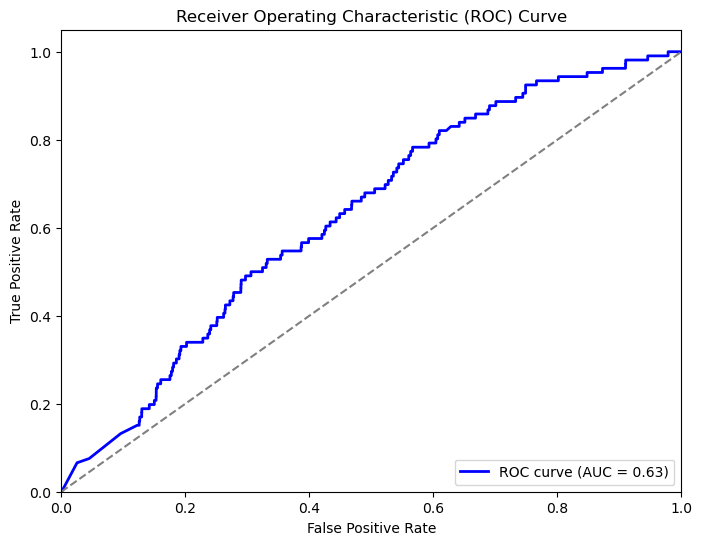

In [95]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (no-skill line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### ITERATION 2:

- Algorithm: XGBoost Classifier
- Pre-processing:
    1. Scaling with StandardScaler()
    2. SMOTE for resampling due to class imbalance

In [55]:
clf_scaler = StandardScaler()

# Transform data
X_scaled = clf_scaler.fit_transform(X)
test_2 = clf_scaler.transform(test)

In [56]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: RESPONSE
0    33943
1      426
Name: count, dtype: int64
After SMOTE: RESPONSE
0    33943
1    33943
Name: count, dtype: int64


In [58]:
# Initialize an XGBoost classifier using the scikit-learn API
xgb_grid = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    random_state=42)


# GridSearchCV Example for Hyperparameter Tuning
param_grid = {
    'max_depth': [6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=1
)

# Perform grid search
grid_search.fit(X_train_smote, y_train_smote)


# Extract the best model
best_model_2 = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [59]:
# Predictions
y_pred = best_model_2.predict(X_test)
y_pred_proba = best_model_2.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Print best parameters and scores
print(f"Best Parameters: {grid_search.best_params_}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100}
Test ROC-AUC Score: 0.69


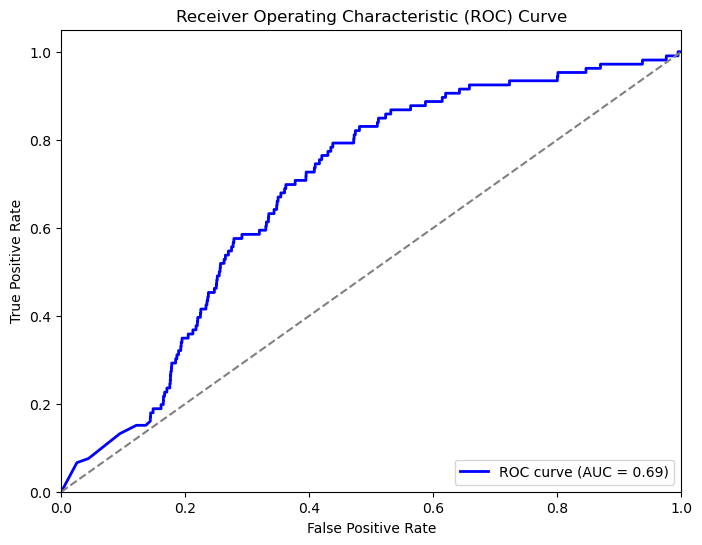

In [60]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (no-skill line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### ITERATION 3:

- Algorithm: XGBoost Classifier
- Pre-processing:
    1. Filtering features to only the ones detected as key features in the customer clusters in Part 1.
    2. Scaling with StandardScaler().
    3. SMOTE for resampling due to class imbalance.

In [61]:
# Separate features and target
columns_to_filter = ['SEMIO_FAM','SEMIO_REL','SEMIO_KRIT','D19_KONSUMTYP_MAX','KOMBIALTER',
                     'KBA05_SEG9','FINANZ_MINIMALIST','KBA05_MOTRAD','KBA13_VORB_1','KBA05_MOD8',
                     'AKT_DAT_KL','SEMIO_RAT','VK_ZG11','SEMIO_TRADV','KBA05_MAXHERST',
                     'KBA13_SEG_KOMPAKTKLASSE','KBA13_HERST_ASIEN','KBA05_HERST5','KBA13_TOYOTA']

# Filter the DataFrame
X_filtered = X[columns_to_filter]
test_filtered = test[columns_to_filter]

In [62]:
filter_scaler = StandardScaler()
# Transform X
X_transformed = filter_scaler.fit_transform(X_filtered)
test_3 = filter_scaler.transform(test_filtered)

In [63]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: RESPONSE
0    33943
1      426
Name: count, dtype: int64
After SMOTE: RESPONSE
0    33943
1    33943
Name: count, dtype: int64


In [65]:
X_train_smote.shape

(67886, 19)

In [66]:
# Initialize an XGBoost classifier using the scikit-learn API
xgb_grid_filter = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    random_state=42)



# GridSearchCV Example for Hyperparameter Tuning
param_grid = {
    'max_depth': [6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 300],
    'min_child_weight': [5, 10, 50]
}


grid_search = GridSearchCV(
    estimator=xgb_grid_filter,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=2
)

# Perform grid search
grid_search.fit(X_train_smote, y_train_smote)


# Extract the best model
best_model_3 = grid_search.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=6, min_chil

In [67]:
# Predictions
y_pred = best_model_3.predict(X_test)
y_pred_proba = best_model_3.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Print best parameters and scores
print(f"Best Parameters: {grid_search.best_params_}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 300}
Test ROC-AUC Score: 0.59


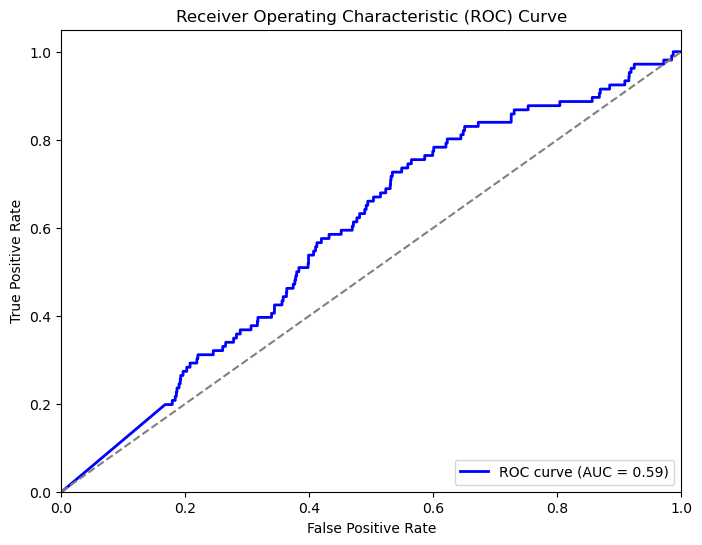

In [68]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (no-skill line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### ITERATION 4:

- Algorithm: AdaBoost Classifier
- Pre-processing:
    2. Scaling with StandardScaler().
    3. SMOTE for resampling due to class imbalance.

In [78]:
ada_scaler = StandardScaler()
# Transform X
X_transformed = ada_scaler.fit_transform(X)
test_4 = ada_scaler.transform(test)

In [79]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

In [80]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: RESPONSE
0    33943
1      426
Name: count, dtype: int64
After SMOTE: RESPONSE
0    33943
1    33943
Name: count, dtype: int64


In [82]:
ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,  # Number of weak learners to train
    learning_rate=1.0,
    random_state=42)


ada.fit(X_train_smote, y_train_smote)


# Predict on the test data
y_pred = ada.predict(X_test)
y_pred_proba = ada.predict_proba(X_test)[:, 1]  # For ROC AUC calculation



# Calculate and print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


ROC AUC Score: 0.623


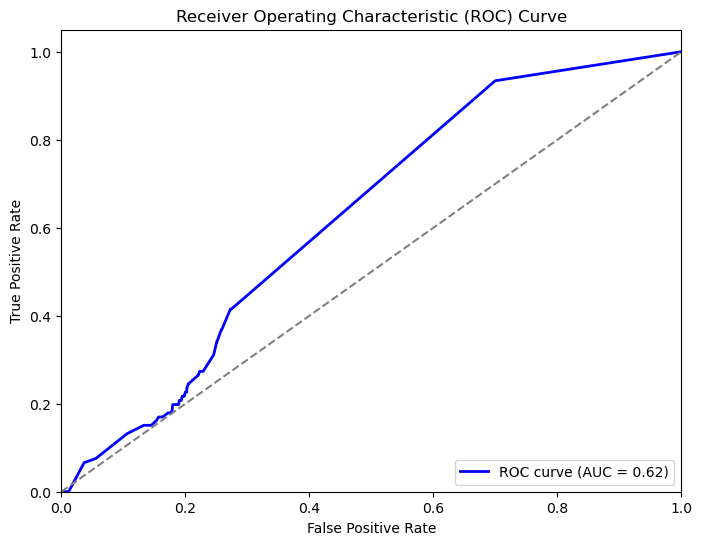

In [84]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (no-skill line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Models Evaluation:

1. Iteration 1: XGBoost + (Scale, PCA, SMOTE) -- 0.63 
2. Iteration 2: XGBoost + (Scale, SMOTE) -- 0.69 **(WINNER)**
3. Iteration 3: XGBoost + (Filtered Features, Scale, SMOTE) -- 0.59
4. Iteration 4: AdaBoost + (Scale, SMOTE) -- 0.62

In [96]:
# Generate predictions
prediction = best_model_2.predict(test_2)


In [97]:
# Convert the predictions (which are a NumPy array) to a pandas DataFrame
prediction_df = pd.DataFrame(prediction, columns=['Prediction'])

# Save the DataFrame with predictions as 'results.csv'
prediction_df.to_csv('results.csv', index=False)

print("Results saved to 'results.csv'")


Results saved to 'results.csv'
